In [66]:
import pandas as pd
import networkx as nx
import heapq
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities


In [10]:
RATINGS = pd.read_csv('drive/MyDrive/Dataset2/ratings.csv')


In [11]:
RATINGS.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [29]:
USERS = RATINGS['userId'].unique().tolist()

In [72]:
print(USERS)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [114]:
SIMILARITY = pd.read_csv('drive/MyDrive/Dataset2/SimilarityOfUsers.csv')
# Clip values to 1.0
SIMILARITY = SIMILARITY.clip(upper=1.0)
# Apply lambda function to replace negative values with 0
SIMILARITY = SIMILARITY.applymap(lambda x: max(0, x))
# Start the row index from 1
SIMILARITY.index = range(1, len(SIMILARITY) + 1)

In [115]:
SIMILARITY.head()

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,1.000000,0.000592,0.070214,0.516196,0.265839,0.346080,0.540215,0.334737,0.041962,0.000000,...,0.158338,0.480139,0.651735,0.139995,0.436931,0.390675,1.000000,1.000000,0.152265,0.410598
2,0.000592,1.000000,0.000000,0.000000,0.000179,0.000585,0.002136,0.000313,0.000000,0.028983,...,0.391775,0.000179,0.000000,0.000000,0.000000,0.008061,0.000086,0.024823,0.000393,0.264532
3,0.070214,0.000000,1.000000,0.000000,0.000020,0.000000,0.000000,0.000019,0.000000,0.000000,...,0.000006,0.000000,0.017177,0.000000,0.000033,0.000000,0.004106,0.015269,0.000000,0.021175
4,0.516196,0.000000,0.000000,1.000000,0.315915,0.255649,0.260805,0.116419,0.000039,0.033166,...,0.150155,0.369353,1.000000,0.068736,0.102317,0.885330,0.353090,0.472530,0.002325,0.193050
5,0.265839,0.000179,0.000020,0.315915,1.000000,1.000000,0.174704,1.000000,0.000000,0.002595,...,0.017527,1.000000,0.337685,0.724984,0.238566,0.317725,0.361205,0.389136,0.526469,0.083756


In [116]:
# Restructure similarity matrix into list of tuples
similarity_results = []
for i in range(len(SIMILARITY)):
    for j in range(i+1, len(SIMILARITY)):
        similarity_results.append((i+1, j+1, SIMILARITY.iloc[i, j]))


In [117]:
def model_complex_network(user_nodes, similarity_results, k, p):
    # Create an empty graph
    G = nx.Graph()

    # Add user nodes to the graph
    G.add_nodes_from(user_nodes)

    # Create a dictionary to store similarity results for each user
    similarity_dict = {u: [] for u in user_nodes}
    for (u, v, sim) in similarity_results:
        similarity_dict[u].append((sim, v))
        similarity_dict[v].append((sim, u))

    # Keep track of used similarities to avoid duplicates
    used_similarities = set()

    # Step 1: Add top p similarities for each user
    for u in user_nodes:
        similarities = similarity_dict[u]
        # Get top p similarities for user u
        top_p_similarities = heapq.nlargest(p, similarities)
        for (sim, v) in top_p_similarities:
            if (u, v, sim) not in used_similarities and (v, u, sim) not in used_similarities:
                G.add_edge(u, v, weight=sim)
                used_similarities.add((u, v, sim))
                used_similarities.add((v, u, sim))

    # Step 2: Add remaining (kn - pn) similarities from the remaining similarities
    remaining_similarities = []
    for u in user_nodes:
        for (sim, v) in similarity_dict[u]:
            if (u, v, sim) not in used_similarities and (v, u, sim) not in used_similarities:
                remaining_similarities.append((sim, u, v))

    # Get top (kn - pn) similarities from the remaining similarities
    total_links = k * len(user_nodes)
    already_added_links = G.number_of_edges()
    remaining_links = total_links - already_added_links

    top_remaining_similarities = heapq.nlargest(remaining_links, remaining_similarities)

    for (sim, u, v) in top_remaining_similarities:
        G.add_edge(u, v, weight=sim)

    return G

def plot_network(G):
    H = G

    pos = nx.spring_layout(H, k=0.1, iterations=20)  # positions for all nodes

    # Draw nodes
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(H, pos, node_size=50, node_color='blue', alpha=0.6)

    # Draw edges
    edges = H.edges(data=True)
    weights = [data['weight'] for _, _, data in edges]
    nx.draw_networkx_edges(H, pos, edgelist=edges, width=0.5, alpha=0.5)

    # Draw edge labels (optional, can be commented out for large graphs)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in H.edges(data=True)}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=6)

    # Draw node labels (optional, can be commented out for large graphs)
    nx.draw_networkx_labels(H, pos, font_size=8, font_family="sans-serif")

    plt.title("Complex Network Based on User Similarities")
    plt.show()

# Example usage:
k = 2
p = 1

network = model_complex_network(USERS, similarity_results, k, p)

# Print edges with weights
for u, v, data in network.edges(data=True):
    print(f"Edge ({u}, {v}) with weight {data['weight']}")



Edge (1, 608) with weight 1.0
Edge (1, 607) with weight 1.0
Edge (1, 600) with weight 1.0
Edge (1, 599) with weight 1.0
Edge (1, 597) with weight 1.0
Edge (2, 495) with weight 0.7596382633965144
Edge (3, 555) with weight 0.1330979447900825
Edge (4, 603) with weight 1.0
Edge (4, 597) with weight 1.0
Edge (5, 602) with weight 1.0
Edge (6, 604) with weight 1.0
Edge (6, 602) with weight 1.0
Edge (7, 608) with weight 1.0
Edge (7, 596) with weight 1.0
Edge (8, 609) with weight 1.0
Edge (8, 604) with weight 1.0
Edge (8, 602) with weight 1.0
Edge (9, 165) with weight 0.373217115996139
Edge (10, 563) with weight 1.0
Edge (10, 143) with weight 0.946917406769794
Edge (11, 602) with weight 1.0
Edge (12, 280) with weight 0.3529870645236934
Edge (13, 591) with weight 0.5528615356351387
Edge (14, 602) with weight 1.0
Edge (15, 601) with weight 1.0
Edge (15, 49) with weight 0.6370549680370422
Edge (15, 272) with weight 0.6144943966048905
Edge (15, 596) with weight 1.0
Edge (16, 601) with weight 1.0
Ed

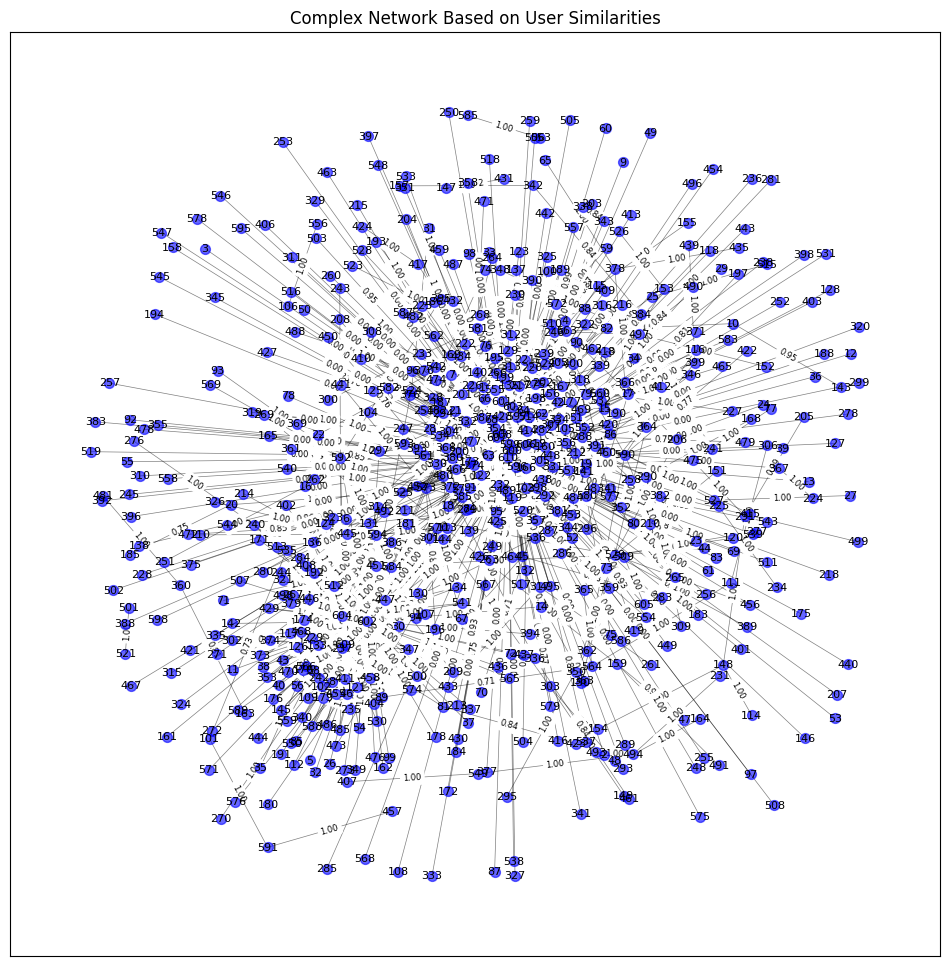

In [112]:
# Plot the network
plot_network(network)

In [124]:
from networkx.algorithms.community.quality import modularity

def calculate_modularity(network, communities):
    # Convert the list of communities to a format accepted by the modularity function
    community_list = [set(community) for community in communities]
    return modularity(network, community_list)

# Detect communities
COMMUNITY = detect_communities(network)

# Print community information
print_communities(COMMUNITY)



Number of clusters: 45

Cluster 1:
Number of users: 157
Users: 1, 514, 3, 4, 517, 518, 519, 520, 19, 533, 23, 28, 542, 545, 34, 547, 36, 548, 552, 41, 42, 555, 562, 51, 53, 57, 59, 572, 576, 64, 66, 68, 587, 593, 82, 595, 84, 597, 87, 599, 600, 603, 606, 95, 607, 96, 608, 100, 103, 104, 108, 122, 128, 132, 135, 137, 140, 144, 156, 160, 167, 169, 172, 182, 187, 195, 198, 199, 200, 201, 202, 207, 215, 217, 219, 221, 222, 223, 225, 226, 232, 236, 238, 250, 253, 255, 263, 264, 266, 267, 268, 275, 278, 281, 282, 285, 286, 287, 288, 293, 294, 298, 301, 304, 307, 310, 313, 316, 320, 322, 324, 325, 329, 346, 354, 356, 359, 363, 370, 372, 375, 376, 385, 387, 390, 391, 396, 397, 403, 406, 409, 410, 412, 414, 416, 420, 425, 427, 428, 430, 440, 442, 448, 449, 452, 453, 462, 464, 465, 469, 479, 482, 484, 489, 502, 504, 508

Cluster 2:
Number of users: 110
Users: 512, 5, 262, 6, 8, 11, 524, 14, 270, 273, 530, 276, 536, 26, 284, 541, 31, 32, 35, 37, 38, 40, 297, 43, 302, 46, 559, 565, 566, 54, 56, 56

In [141]:

def communities_to_dataframe(communities):
    # Initialize an empty list to store dictionaries
    rows = []

    # Iterate through the communities
    for i, community in enumerate(communities):
        # Concatenate user IDs into a string
        user_ids = ', '.join(map(str, community))

        # Append cluster number and user IDs as a dictionary
        rows.append({'Cluster Number': i+1, 'User IDs': user_ids})

    # Convert the list of dictionaries into a DataFrame

    df = pd.DataFrame(rows)

    return df

# Convert communities to DataFrame
NETWORK_CLUSTER = communities_to_dataframe(COMMUNITY)
NETWORK_CLUSTER.head(50)

,Cluster Number,User IDs
0,1,"1, 514, 3, 4, 517, 518, 519, 520, 19, 533, 23,..."
1,2,"512, 5, 262, 6, 8, 11, 524, 14, 270, 273, 530,..."
2,3,"256, 258, 515, 7, 522, 15, 16, 272, 274, 18, 2..."
3,4,"265, 333, 590, 527, 24, 218, 27, 415, 224, 355..."
4,5,"544, 451, 389, 71, 456, 364, 44, 206, 492, 269..."
5,6,"161, 426, 491, 12, 525, 47, 506, 20, 280, 185,..."
6,7,"131, 419, 580, 69, 75, 399, 400, 83, 405, 439,..."
7,8,"581, 523, 300, 60, 241, 497, 118, 471, 152, 44..."
8,9,"578, 358, 583, 10, 175, 143, 177, 146, 563"
9,10,"289, 513, 259, 303, 48, 244, 149, 570"


In [145]:
def cluster_user_count(communities):
    # Initialize an empty list to store cluster numbers and corresponding user counts
    cluster_user_counts = []

    # Iterate through the communities
    for i, community in enumerate(communities):
        # Get the number of users in the current community
        user_count = len(community)

        # Append cluster number and user count as a tuple
        cluster_user_counts.append((i+1, user_count))

    return cluster_user_counts

# Detect communities

# Get cluster numbers and corresponding user counts
cluster_counts = cluster_user_count(COMMUNITY)

# Create DataFrame
NUMBER_OF_USER_IN_EACH_CLUSTER = pd.DataFrame(cluster_counts, columns=['Cluster Number', 'Number of Users'])

# Print DataFrame
NUMBER_OF_USER_IN_EACH_CLUSTER.head()

,Cluster Number,Number of Users
0,1,157
1,2,110
2,3,107
3,4,20
4,5,18


In [146]:
NUMBER_OF_USER_IN_EACH_CLUSTER.to_csv('drive/MyDrive/Dataset2/NUMBER_OF_USER_IN_EACH_CLUSTER.csv')